# Preliminaries and Imports
In the following cell, the necessary packages and libraries are imported.

In [78]:
# access to different databases
import pandas_datareader as web
import quandl as quandl
import wrds as wrds

# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from tqdm import tqdm
import time

# statistics and regression
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy.stats.mstats import winsorize
import quantstats as qs
from scipy.optimize import minimize 

# indicators
import ta as ta
from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.trend import AroonIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from pandas.tseries.offsets import BDay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.axis import Axis
import matplotlib.dates as mdates 
%matplotlib inline

# warning
import warnings
warnings.filterwarnings("ignore")

# unzipping zip-files
from zipfile import ZipFile

pd.set_option('display.max_columns', None)

# Data Imports and Preperations

In [13]:
# define an useful path
#path = Path('/Users/sebastiansydow/13_Quant_Trading/Group_Project')
#path = Path(r'\Users\Strahinja\Desktop\books_Germany\Quant\Group_Project')
path = Path(r'C:\Users\choux\OneDrive\quantative_trading')
# stocks
input_stocks = path / 'permno_selection.csv'
# link betweeen CRSP (permno) and Option Metrics (SECID)
link_permno_secid = path / 'daily_permno_secid_cusip_link.csv.zip'
# glb
glb = path / 'glb_daily.csv'
# model-free implied skewness (MFIS)
mfis = path / 'mfis.csv'
# Save a hdf locally for easier modeling
hdf_path = path / 'factors.h5'
#quandl key
quandl_key = path / 'quandl_key.xlsx'
#quandl_key = 'XWVLTpJSLyiA8s66Fh8x'
# import stocks from S&P 500 into a pandas dataframe
df_input_stocks = pd.read_csv(input_stocks)
# glb
df_glb = pd.read_csv(glb)
## rename column
df_glb = df_glb.rename(columns={"id": "permno"})
## transfrom data type
df_glb['date'] = pd.to_datetime(df_glb['date'])
# mfis
df_mfis = pd.read_csv(mfis)
## rename column
df_mfis = df_mfis.rename(columns={"id": "permno"})
## transfrom data type
df_mfis['date'] = pd.to_datetime(df_mfis['date'])
# instantiate zip-file
zip_file = ZipFile(link_permno_secid)
# load linking table
df_link_permno_secid = pd.read_csv(zip_file.open('daily_permno_secid_cusip_link.csv'))

## Daily Stock Returns, Market Capitalization and Value Weights

In [3]:
def retrieve_stock_data(df_input, date_start, date_end, wrds_username):
    # Download stock data
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # create query to load the returns, prices and shares outstanding for S&P 500 companies from 1999/01
    sql_wrds = """
            select distinct date, 
                            permno,
                            cusip, 
                            ret, 
                            abs(prc) as prc, 
                            shrout,
                            abs(prc)*shrout/1000 as mktval
            from crsp.dsf 
            where permno in %(permno)s and date>=%(start)s and date<=%(end)s
            order by date, permno
            """

    # define the parameters, i.e. only those companies (permno), which were part of the S&P 500
    # in the timeframe 2000/01 until 2020/12
    params = {}
    params['start'] = date_start
    params['end'] = date_end
    params['permno'] = tuple(df_input.permno.unique().astype(str))

    # retrieve the data from wrds
    df_stock_data = db.raw_sql(sql_wrds, params = params)

    # change type of entries in the columns start and ending
    df_stock_data['date']  = pd.to_datetime(df_stock_data['date'])
    
    # shift market_val by 1 day
    df_stock_data.loc[:,'mktval_shifted'] = df_stock_data.groupby(['permno'])['mktval'].shift(1)
    
    # dropna
    df_stock_data.dropna(inplace=True)
    
    # calculate weight of each stock on each day
    ## dataframe with total market value on each day
    df_ttl_mkcap = df_stock_data[['date', 'mktval_shifted']].groupby('date').sum().rename(columns={"mktval_shifted": "ttl_mktval"})
    ## merge with df_stock_data
    df_stock_data = pd.merge(df_stock_data, df_ttl_mkcap, how='left', on=['date'])
    ## calculate weightage
    df_stock_data['weightage_pct'] =  df_stock_data['mktval_shifted'] / df_stock_data["ttl_mktval"]
    ## drop columns
    df_stock_data.drop(columns = {'shrout', 'mktval', 'mktval_shifted', 'ttl_mktval'}, inplace = True)
    
    return df_stock_data.sort_values(by=['date']).reset_index(drop=True)

## Fama-French-Factors

In [4]:
def download_ffm(date_start, date_end):
    # start of time period 
    startdt = datetime.datetime(int(date_start[:4]),
                                int(date_start[5:7]),
                                int(date_start[8:]))
    
    # end of time period                            
    enddt = datetime.datetime(int(date_end[:4]),
                              int(date_end[5:7]),
                              int(date_end[8:]))

    # define which dataset are to be downloaded
    d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt, end=enddt)
    d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt, end=enddt)

    # key is 0 -> get returns data
    # divide by 100 to get the returns
    df_ff_3factor = d1[0]/100

    # add momentum factor with an outer-join
    # outer-join: keep all data -> union
    df_ff_4factor = df_ff_3factor.join(d2[0]/100, how = 'outer')

    # reset index for merge later
    df_ff_4factor = df_ff_4factor.reset_index()

    # change columns to be small letters and get rid of white-spaces
    df_ff_4factor.columns = [z.lower().strip() for z in df_ff_4factor.columns]

    # rename column
    df_ff_4factor.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

    # change order of dataframe
    df_ff_4factor = df_ff_4factor.loc[:,['date', 'mktrf', 'smb', 'hml', 'mom', 'rf']]
                              
    return df_ff_4factor

## Quandl Data

### Crude Oil Prices
- [WTI Spot Price](https://data.nasdaq.com/data/EIA/PET_RWTC_D-cushing-ok-wti-spot-price-fob-daily)
- More Info, see [here](https://ycharts.com/indicators/wti_crude_oil_spot_price)

### Treasury Yields
- [US Treasury Yields](https://data.nasdaq.com/data/USTREASURY/YIELD-treasury-yield-curve-rates)

### Gold
- [LBMA/GOLD](https://data.nasdaq.com/data/LBMA/GOLD-gold-price-london-fixing)

In [11]:
def get_quandl_data(quandl_key):
    # retrieve quandl key
    temp = pd.read_excel(quandl_key)

    # configure quandl
    quandl.ApiConfig.api_key = temp.iloc[0,0]
    
    # Crude Oil
    df_crude_oil = quandl.get("EIA/PET_RWTC_D")
    # calculate daily returns
    df_crude_oil = df_crude_oil.pct_change(1)
    # reset_index
    df_crude_oil.reset_index(inplace=True)
    # rename column
    df_crude_oil.rename(columns={"Value": "ret_crude_oil", "Date": "date"}, inplace=True)
    
    # Treasury Yields
    df_treasury_yield = quandl.get("USTREASURY/YIELD")
    # drop columns
    df_treasury_yield.drop(labels=['1 MO', '2 MO', '3 MO', '6 MO', '2 YR', '3 YR', '5 YR', '7 YR', '20 YR', '30 YR'], axis=1, inplace=True)
    # calculate difference between 10year yield and 1year yield
    df_treasury_yield['yield_dif_10y_1y'] = df_treasury_yield['10 YR'] - df_treasury_yield['1 YR']
    # drop columns
    df_treasury_yield.drop(labels=['1 YR', '10 YR'], axis=1, inplace=True)
    # reset_index
    df_treasury_yield.reset_index(inplace=True)
    # rename column
    df_treasury_yield.rename(columns={"Date": "date"}, inplace=True)
    
    # Gold
    df_gold = quandl.get("LBMA/GOLD")
    # drop columns
    df_gold.drop(labels=['USD (PM)','GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], axis=1, inplace=True)
    # calculate daily returns
    df_gold = df_gold.pct_change(1)
    # reset_index
    df_gold.reset_index(inplace=True)
    # rename column
    df_gold.rename(columns={"USD (AM)": "ret_gold", "Date": "date"}, inplace=True)
    
    return df_crude_oil, df_treasury_yield, df_gold

## Exchange Rates
- [Exchange Rates ST. Louis FRED](https://fred.stlouisfed.org/categories/15)
- [Nominal Emerging Market Economies U.S. Dollar Index](https://fred.stlouisfed.org/series/DTWEXEMEGS), only available from 2006 onwards
- [Real Emerging Market Economies Dollar Index](https://fred.stlouisfed.org/series/RTWEXEMEGS), only available from 2006 onwards

In [6]:
def get_fx_data(symbol, start_date):
    # get data
    df_fx = data.DataReader(symbol, 'fred', start_date)
    # calculate daily returns
    df_fx = df_fx.pct_change(1)
    # reset index
    df_fx.reset_index(inplace=True)
    # rename
    df_fx.rename(columns={'DATE': 'date', symbol: 'fx_rates'}, inplace=True)
    
    return df_fx

## Calculate Excess Return

In [7]:
def calc_excess_return(df, minuend, subtrahend):
    # calculate excess return
    df['excess_return'] = df[minuend]-df[subtrahend]
    return df

## Perfrom Data Preparation 

In [8]:
def data_prep(df_input, date_start, date_end, df_link, wrds_username, minuend, subtrahend, quandl_key):

    ## retrieve data
    df_stock_data = retrieve_stock_data(df_input=df_input_stocks, 
                                        date_start=date_start, 
                                        date_end=date_end, 
                                        wrds_username=wrds_username)
    
    # change type of entries in the columns date
    df_link['date']  = pd.to_datetime(df_link['date'])
    
    ## merge with cusip
    df_stock_data = pd.merge(df_stock_data, df_link.loc[:,['permno', 'date', 'secid']], how = "left", on = ['permno','date'])
    
    
    # Download Fama-French Factors
    df_ffm = download_ffm(date_start=date_start, date_end=date_end)
    
    ## merge stock data with ffm
    # merge with ff-4-factors
    df_stocks_factors = pd.merge(df_stock_data, df_ffm, how='inner', on=['date'])
    
    # calculate excess return
    df_stocks_factors  = calc_excess_return(df=df_stocks_factors, minuend=minuend, subtrahend=subtrahend)
    
    # get quandl data
    df_crude, df_yields, df_gold = get_quandl_data(quandl_key=quandl_key)
    ## merge with stock data
    df_stocks_factors = pd.merge(df_stocks_factors, df_crude, how='left', on=['date'])
    df_stocks_factors = pd.merge(df_stocks_factors, df_yields, how='left', on=['date'])
    df_stocks_factors = pd.merge(df_stocks_factors, df_gold, how='left', on=['date'])
    
    return df_stocks_factors

In [16]:
df_prepared = data_prep(df_input=df_input_stocks,
                        date_start='1999-01-01',
                        date_end='2019-12-31',
                        df_link=df_link_permno_secid,
                        #wrds_username='sebastiansydow',
                        wrds_username = 'chouxy141319',
                        minuend='ret',
                        subtrahend='rf', 
                        quandl_key=quandl_key)

Loading library list...
Done
                 header
0  e_bjszvys_8CDwsLx3uN


In [17]:
df_prepared

,date,permno,cusip,ret,prc,weightage_pct,secid,mktrf,smb,hml,mom,rf,excess_return,ret_crude_oil,yield_dif_10y_1y,ret_gold
0,1999-01-05,10874.0,11704310,0.018519,24.062500,0.001989,102386.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.018329,-0.030596,0.18,-0.004337
1,1999-01-05,47466.0,65011110,0.030965,35.375000,0.005459,108117.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.030775,-0.030596,0.18,-0.004337
2,1999-01-05,47626.0,12611710,0.000000,40.375000,0.006508,102548.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,-0.000190,-0.030596,0.18,-0.004337
3,1999-01-05,48486.0,51280710,0.328947,25.250000,0.000640,106808.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.328757,-0.030596,0.18,-0.004337
4,1999-01-05,51369.0,88077010,0.083086,45.625000,0.003107,110952.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.082896,-0.030596,0.18,-0.004337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264092,2019-12-31,24205.0,65339F10,0.003606,242.160004,0.041459,104560.0,0.0028,-0.0001,0.0012,-0.0047,0.00007,0.003536,-0.008433,0.33,0.007608
264093,2019-12-31,25320.0,13442910,0.003452,49.419998,0.005214,102660.0,0.0028,-0.0001,0.0012,-0.0047,0.00007,0.003382,-0.008433,0.33,0.007608
264094,2019-12-31,26825.0,48783610,0.005525,69.160004,0.008247,106638.0,0.0028,-0.0001,0.0012,-0.0047,0.00007,0.005455,-0.008433,0.33,0.007608
264095,2019-12-31,18411.0,84258710,0.005684,63.700001,0.023351,110337.0,0.0028,-0.0001,0.0012,-0.0047,0.00007,0.005614,-0.008433,0.33,0.007608


# Estimation of $\beta$-Factors

In [18]:
def estimate_betas(df, window_size, factors, period='daily'):
    # identify all companies (permnos) in the dataframe
    permnos = df.permno.unique()
    # loop over all permnos and perform ols regression
    for permno in tqdm(range(len(permnos))):
        # define dataframe only with current permno
        df_current_permno = df[df['permno'] == permnos[permno]]
        # only perform OLS for stocks with more than 252 observations
        if len(df_current_permno) > window_size:
            # dependent variable
            Y = df_current_permno['excess_return']
            # independent variable
            X = df_current_permno[factors]
            # define constant
            X_constant = sm.add_constant(X)
            # define model
            rol_ols_model = RollingOLS(endog=Y, exog=X_constant, window=window_size)
            # fitting
            # print('Fitting rolling OLS model for permno #', permno, ' from', len(permnos))
            results = rol_ols_model.fit()
            # parameters
            if permno == 0:
                df_params = results.params
            else:
                df_params = pd.concat([df_params, results.params])

    # rename columns
    for col in factors:
        df_params.rename(columns={col: col+str('_beta')}, inplace=True)
    # df_params.rename(columns = {'mktrf':'beta1', 'smb':'beta2', 'hml':'beta3', 'mom': 'beta4'}, inplace = True)
    # merge with df_all by index
    print('Merging the dataframes...')
    df_betas = pd.merge(df, df_params, how='left', left_index=True, right_index=True, suffixes=[None, None])
    print('Merging completed.')
    
    if period == 'daily':
        df_betas.dropna(inplace=True)
        df_betas = df_betas.reset_index(drop=True)
        return df_betas
    
    if period == 'monthly':
        # add '_factor' to the entries in list factors
        ls_factors_betas = [factors[i] + str('_beta') for i in list(range(len(factors)))]
        # create a temporary copy of df_betas
        cols2copy=['permno', 'date', 'const']+ls_factors_betas
        df_temp = df_betas[cols2copy].copy()
        #df_temp = df_betas[['permno', 'date', 'const', 'beta1', 'beta2', 'beta3', 'beta4']].copy()

        # add necessary columns for group by
        df_temp['year'] = df_temp['date'].dt.year
        df_temp['month'] = df_temp['date'].dt.month
        # group dataframe and select last row 
        df_temp = df_temp.groupby(['permno','year', 'month']).tail(n=1)
        
        # rename columns to indicate that those are the betas of the end of each month
        for col in cols2copy[2:]:
            df_temp.rename(columns={col: col+str('_eom')}, inplace=True)
        # df_temp.rename(columns = {'const':'const_eom', 'beta1':'beta1_eom', 'beta2':'beta2_eom', 'beta3':'beta3_eom', 'beta4':'beta4_eom'}, inplace = True)
        # merge with df_betas
        df_betas_monthly = pd.merge(df_betas, df_temp, how='left', on=['date', 'permno'])
        # forward fill estimaed beta factors to assume that they stay constant for the next month until the last day
        gb = df_betas_monthly.groupby('permno')
        cols_eom = cols2copy[2:]
        cols_eom = [cols_eom[i] + str('_eom') for i in list(range(len(cols_eom)))]
        for var in cols_eom:
            df_betas_monthly[var] = gb[var].ffill()
        
        # drop daily betas
        #df_betas_monthly.drop(columns = {'const', 'beta1', 'beta2', 'beta3', 'beta4', 'year', 'month'}, inplace = True)
        df_betas_monthly.drop(['const', 'year', 'month'] + ls_factors_betas + factors, axis = 1, inplace=True)
        # drop nas
        df_betas_monthly.dropna(inplace=True)

        # reset index of df
        df_betas_monthly = df_betas_monthly.reset_index(drop=True)
        
        return df_betas_monthly

In [21]:
factors = ['mktrf', 'smb', 'hml', 'mom', 'ret_crude_oil', 'yield_dif_10y_1y', 'ret_gold']

df_betas = estimate_betas(df=df_prepared, window_size=252, factors=factors, period='monthly')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]


Merging the dataframes...
Merging completed.


In [73]:
df_betas

,date,permno,cusip,ret,prc,weightage_pct,secid,rf,excess_return,const_eom,mktrf_beta_eom,smb_beta_eom,hml_beta_eom,mom_beta_eom,ret_crude_oil_beta_eom,yield_dif_10y_1y_beta_eom,ret_gold_beta_eom
0,2000-01-31,64936.0,25746U10,0.027692,41.750000,0.006924,103912.0,0.00021,0.027482,-0.007351,0.331790,-0.367301,0.388610,-0.242656,-0.055550,0.014133,0.008290
1,2000-01-31,61241.0,00790310,0.021277,36.000000,0.004653,101121.0,0.00021,0.021067,-0.014037,1.646005,0.654376,1.157603,0.757662,0.120219,0.023104,0.073511
2,2000-01-31,56274.0,20588710,0.036254,21.437500,0.009096,103313.0,0.00021,0.036044,-0.008199,0.556153,-0.547886,0.169765,-0.320454,-0.052706,0.012303,-0.058422
3,2000-01-31,53613.0,59511210,0.036458,62.187500,0.013615,107544.0,0.00021,0.036248,-0.020530,0.592734,-0.194392,-0.297182,0.466429,-0.010334,0.033147,-0.092205
4,2000-01-31,47626.0,12611710,0.014981,33.875000,0.005497,102548.0,0.00021,0.014771,0.000948,1.022090,0.078209,0.860304,-0.210158,-0.015706,-0.000706,0.044433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250592,2019-12-31,24205.0,65339F10,0.003606,242.160004,0.041459,104560.0,0.00007,0.003536,0.001335,0.341386,-0.105268,0.070199,0.644105,0.008150,-0.002475,0.045836
250593,2019-12-31,25320.0,13442910,0.003452,49.419998,0.005214,102660.0,0.00007,0.003382,0.001713,0.492465,-0.077780,0.248798,0.351407,-0.033480,-0.003192,0.191344
250594,2019-12-31,26825.0,48783610,0.005525,69.160004,0.008247,106638.0,0.00007,0.005455,0.000117,0.552991,-0.167625,-0.065833,0.203916,-0.086936,0.003647,0.126109
250595,2019-12-31,18411.0,84258710,0.005684,63.700001,0.023351,110337.0,0.00007,0.005614,0.001573,0.351593,-0.053078,0.278846,0.565044,-0.008463,0.000003,-0.018999


# Plotting of Return

In [22]:
# define a function to calculate the valued weighted average
def weighted_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [35]:
def plot_benchmark_performance(df, column_ret, column_weight):
    # calculate benchmark performance on each day
    df_plot = (df.groupby(['date']).apply(weighted_avg, column_ret, column_weight)+1)
    df_plot.iloc[0] = df_plot.iloc[0] * 100
    
    # size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    # define the spacing on the x-axis
    ## major ticks every 4 years
    major_ticks_years = mdates.YearLocator(4)  
    Axis.set_major_locator(ax.xaxis, major_ticks_years) 
    ## Minor ticks every year 
    minor_ticks_year = mdates.YearLocator(1)
    Axis.set_minor_locator(ax.xaxis, minor_ticks_year)

    # title
    plt.title(r"Value-Weighted Return of the Benchmark-Portfolio")

    # format the date type to year on the x-axis
    ax.format_xdata = mdates.DateFormatter('% m')

    # 9/11
    ax.annotate('9/11', xy=(pd.to_datetime('2001-09-11'), 120), xytext=(15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2001-09-11'), color='r', linestyle='--', lw=1)

    # bankruptcy Lehman 
    ax.annotate('Bankruptcy Lehman Brothers', xy=(pd.to_datetime('2008-09-15'), 90), xytext=(15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2008-09-15'), color='r', linestyle='--', lw=1)

    # covid
    #     ax.annotate('Covid-19', xy=(pd.to_datetime('2020-03-16'), 350), xytext=(-60, 5), 
    #                 textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    #     ax.axvline(x=pd.to_datetime('2020-03-16'), color='r', linestyle='--', lw=1)

    # define start and end of x-axis
    ax.set_xlim(min(df['date']), max(df['date']))

    # define labels of x- and y-axis
    ax.set(xlabel="Date",
           ylabel="Performance in % (Value-Weighted Mean of Benchmark Portfolio)")

    ax.plot(df_plot.cumprod(), label="Return Benchmark")
    ax.legend(loc="upper left")
    # df_plot.cumprod().plot(figsize=(10,10))
    
    # quant_stats
    # qs.reports.html(df_plot.cumprod())

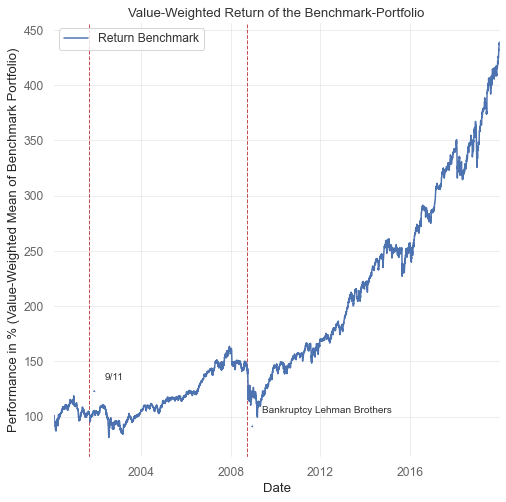

In [75]:
plot_benchmark_performance(df=df_betas, column_ret='ret', column_weight='weightage_pct')

# Option-Implied Data and Option Metrics
## GLB and MFIS

In [37]:
# merge data with glb
df_stocks_betas_options = pd.merge(df_betas, df_glb, how="left", on=['permno', 'date'])
# merge data with mfis
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_mfis, how='left', on=['permno', 'date'])

### Average Volatility [AIV] of all OTM Call and Put Options and SKEW

In [38]:
def retrieve_option_metrics(df, start_year, end_year, days, delta_otm_put, delta_atm_call, delta_otm_put2, delta_atm_call2, wrds_username):
    
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # define the parameters
    params = {}
    params['secids'] = tuple(df.secid.unique())
    params['days'] = days
    params['delta_otm_put'] = delta_otm_put
    params['delta_atm_call'] = delta_atm_call
    params['delta_otm_put2'] = delta_otm_put2
    params['delta_atm_call2'] = delta_atm_call2

    # define the sql query
    sql = '''
    select a.date, a.secid, a.iv-b.iv as skew1, c.iv, (g.iv-v.iv)/a.iv as skew2 from 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call)s) as a, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put)s) as b, 

    (select date, secid, AVG(impl_volatility) as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and abs(delta)<=%(delta_atm_call)s
    group by date, secid) as c,
    
    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put2)s) as g, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call2)s) as v

    where a.date= b.date and a.secid = b.secid 
    and a.date = c.date and a.secid = c.secid
    and a.date = g.date and a.secid = g.secid
    and a.date = v.date and a.secid = v.secid
    '''
    # retrieve data for 1999
    params['year'] = start_year
    df_optiondata = db.raw_sql(sql, params = params)

    # append data for each year from 2000 to 2020
    for y in tqdm(range(start_year+1,end_year)):
        #print('Processing year ', y)
        # set parameter for the year
        params['year'] = y
        df_optiondata = pd.concat([df_optiondata, db.raw_sql(sql, params = params)])
        
    return df_optiondata

In [39]:
df_option_metrics = retrieve_option_metrics(df=df_stocks_betas_options,
                                            start_year=1999,
                                            end_year=2020,
                                            days=30,
                                            delta_otm_put=-10,
                                            delta_atm_call=50,
                                            delta_otm_put2=-25,
                                            delta_atm_call2=25,  # TODO: I think this is OTM CALL???
                                            #wrds_username="strahinja23
                                            wrds_username="chouxy141319")

# change type of entries in the column data
df_option_metrics.loc[:,'date'] = pd.to_datetime(df_option_metrics.loc[:,'date'])

# merge optiondata and stockdata
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_option_metrics, how='left', on=['secid', 'date'])

Loading library list...
Done


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.41s/it]


In [43]:
#df_stocks_betas_options.to_hdf(hdf_path, key = 'factors', mode= 'a',data_columns = True, complib = 'zlib')
df_stocks_betas_options = pd.read_hdf(hdf_path,key='factors')

In [79]:
df_stocks_betas_options

,date,permno,cusip,ret,prc,weightage_pct,secid,rf,excess_return,const_eom,mktrf_beta_eom,smb_beta_eom,hml_beta_eom,mom_beta_eom,ret_crude_oil_beta_eom,yield_dif_10y_1y_beta_eom,ret_gold_beta_eom,glb3_D30,mfis91,skew1,iv,skew2
0,2000-01-31,64936.0,25746U10,0.027692,41.750000,0.006924,103912.0,0.00021,0.027482,-0.007351,0.331790,-0.367301,0.388610,-0.242656,-0.055550,0.014133,0.008290,0.021007,-0.156855,-0.231987,0.274665,0.144521
1,2000-01-31,61241.0,00790310,0.021277,36.000000,0.004653,101121.0,0.00021,0.021067,-0.014037,1.646005,0.654376,1.157603,0.757662,0.120219,0.023104,0.073511,0.132537,-0.149608,-0.015606,0.846875,0.021193
2,2000-01-31,56274.0,20588710,0.036254,21.437500,0.009096,103313.0,0.00021,0.036044,-0.008199,0.556153,-0.547886,0.169765,-0.320454,-0.052706,0.012303,-0.058422,0.039052,-0.290512,-0.022562,0.358979,0.070496
3,2000-01-31,53613.0,59511210,0.036458,62.187500,0.013615,107544.0,0.00021,0.036248,-0.020530,0.592734,-0.194392,-0.297182,0.466429,-0.010334,0.033147,-0.092205,0.072998,-0.217050,-0.081795,0.781999,0.082545
4,2000-01-31,47626.0,12611710,0.014981,33.875000,0.005497,102548.0,0.00021,0.014771,0.000948,1.022090,0.078209,0.860304,-0.210158,-0.015706,-0.000706,0.044433,0.097734,-0.269776,-0.056261,0.449849,0.139864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250592,2019-12-31,24205.0,65339F10,0.003606,242.160004,0.041459,104560.0,0.00007,0.003536,0.001335,0.341386,-0.105268,0.070199,0.644105,0.008150,-0.002475,0.045836,0.010840,-1.121445,-0.064962,0.162300,0.201017
250593,2019-12-31,25320.0,13442910,0.003452,49.419998,0.005214,102660.0,0.00007,0.003382,0.001713,0.492465,-0.077780,0.248798,0.351407,-0.033480,-0.003192,0.191344,0.010840,-0.832878,-0.065431,0.172134,0.209328
250594,2019-12-31,26825.0,48783610,0.005525,69.160004,0.008247,106638.0,0.00007,0.005455,0.000117,0.552991,-0.167625,-0.065833,0.203916,-0.086936,0.003647,0.126109,0.012270,-0.604388,-0.041654,0.203370,0.096874
250595,2019-12-31,18411.0,84258710,0.005684,63.700001,0.023351,110337.0,0.00007,0.005614,0.001573,0.351593,-0.053078,0.278846,0.565044,-0.008463,0.000003,-0.018999,0.010840,-1.096413,-0.079139,0.148569,0.224596


# Data Cleaning

## Delete Columns with many NaNs

In [80]:
def count_nan(df):
    # Count NaN
    df_count_nan = df.isna().sum().reset_index(name="Count NaN")
    # Rename column
    df_count_nan = df_count_nan.rename(columns={"index": "Column"})
    # Plot
    df_count_nan.plot.bar(x='Column', 
                          y='Count NaN', 
                          rot=90, #45, 
                          figsize=(16,6), 
                          title="Count NaN per Column")

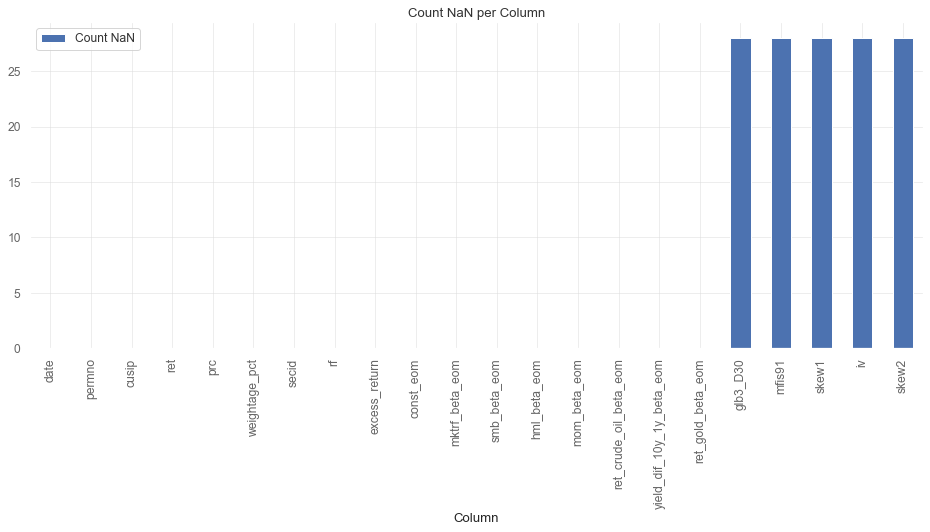

In [81]:
count_nan(df=df_stocks_betas_options)  # TODO: Rerun this, now it is showing the result after latter processing

In [46]:
# drop columns with many nas
df_stocks_betas_options.drop(['glb2_D182', 
                              'glb3_D182', 
                              'glb2_D273', 
                              'glb3_D273', 
                              'glb2_D365', 
                              'glb3_D365',
                              'mfis182',
                              'mfis273', 
                              'mfis365'], inplace=True, axis=1)

## Multicollinearity

In [47]:
def corrmatrix_heatmap(df, columns):
    
    X = df[columns]

    # Compute the correlation matrix
    corrMatrix = X.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    sns.heatmap(corrMatrix, annot=True)
    # plt.savefig('corrMatrix_heatmap.jpeg', dpi=200, format='jpeg')

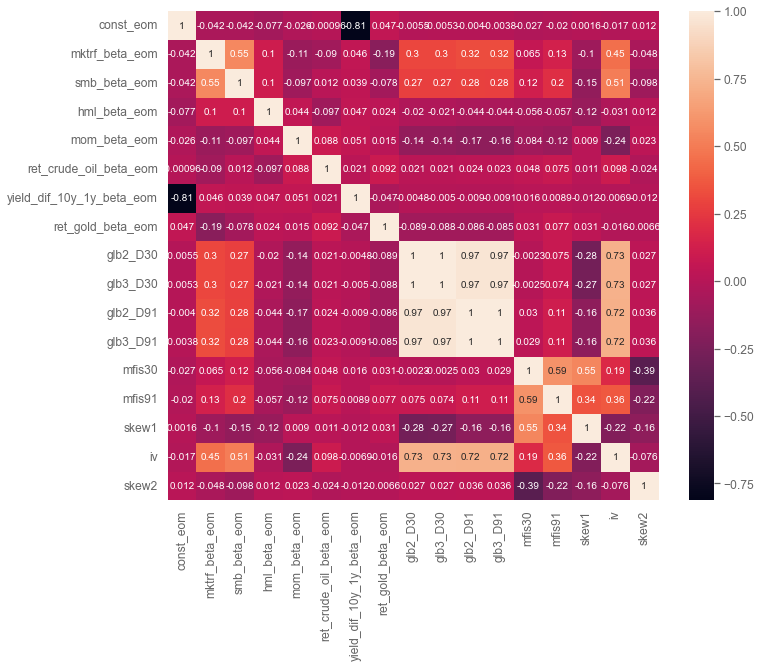

In [48]:
# define columns to calculate pearson correlation coefficient for
idx = list(df_stocks_betas_options.columns).index("excess_return")
columns = list(df_stocks_betas_options.columns)[idx+1:]

# execute function
corrmatrix_heatmap(df=df_stocks_betas_options, columns=columns)

In [49]:
def VIF_Features(df):
    
    X_ = df.copy()
    X_ = X_[X_.columns[10:]]
    X_ = X_.dropna()
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_.columns
    vif_data["VIF"] = [variance_inflation_factor(X_.values, i) for i in range(len(X_.columns))]
    
    return vif_data

In [50]:
dd = VIF_Features(df_stocks_betas_options)
dd

,feature,VIF
0,mktrf_beta_eom,7.156931
1,smb_beta_eom,1.507694
2,hml_beta_eom,1.064595
3,mom_beta_eom,1.119772
4,ret_crude_oil_beta_eom,1.076671
5,yield_dif_10y_1y_beta_eom,1.011796
6,ret_gold_beta_eom,1.069805
7,glb2_D30,72954.025983
8,glb3_D30,72774.632769
9,glb2_D91,75847.966603


TODO: Add explanation to the table.

In [51]:
# drop columns
df_stocks_betas_options.drop(['glb2_D30', 
                              #'glb3_D30', 
                              'glb2_D91', 
                              'glb3_D91',
                              'mfis30'], inplace=True, axis=1)

In [52]:
dd = VIF_Features(df_stocks_betas_options)
dd

,feature,VIF
0,mktrf_beta_eom,7.050383
1,smb_beta_eom,1.496538
2,hml_beta_eom,1.059941
3,mom_beta_eom,1.103010
4,ret_crude_oil_beta_eom,1.074088
5,yield_dif_10y_1y_beta_eom,1.011156
6,ret_gold_beta_eom,1.065038
7,glb3_D30,3.438370
8,mfis91,3.656490
9,skew1,2.565189


## Code for Normalization and Rolling Window regression

In [53]:
def train_test_split_sorted(df,date_of_split, dates):   
    # TODO: I think this can be randomized for train, please refer the reason to the bottom.
    
    date_of_split = pd.to_datetime(date_of_split)
    X_train = df[(df["date"] <= date_of_split) & (df['date'] > pd.datetime(1999, 12, 31))]
    X_test = df[(df["date"] > date_of_split) & (df['date'] < pd.datetime(2020, 1, 1))]
    
    X_train = X_train.sort_values(by=['date','permno'])
    X_test = X_test.sort_values(by=['date','permno'])

    return X_train,X_test

In [54]:
df_stocks_betas_options.loc[:,'date'] = pd.to_datetime(df_stocks_betas_options.loc[:,'date'])


train,test = train_test_split_sorted(df=df_stocks_betas_options,
                                     date_of_split=pd.datetime(2012, 12, 31),
                                     dates=df_stocks_betas_options.date)

In [55]:
def technicals_rock(df_a):
    
    KAMA = KAMAIndicator(close = df_a["prc"],window = 10,pow1 = 2, pow2 = 30)
    PPO = PercentagePriceOscillator(close = df_a["prc"],window_slow = 26, window_fast = 12, window_sign = 9)
    ROCI = ROCIndicator(close=df_a["prc"],window=12)
    RSI = RSIIndicator(close=df_a["prc"],window = 14)
    EMA14 = EMAIndicator(close = df_a["prc"],window = 14)
    EMA25 = EMAIndicator(close = df_a["prc"],window = 25)
    MACD_ind = MACD(close = df_a["prc"],window_slow = 26,window_fast = 12,window_sign=9)
    Aroon = AroonIndicator(close = df_a["prc"],window = 25)
    
    df_a = df_a.assign(    
    KAMA = KAMA.kama(),
    PPO = PPO.ppo_signal(),
    ROCI = ROCI.roc(),
    RSI = RSI.rsi(),
    EMA14 = EMA14.ema_indicator(),
    EMA25 = EMA25.ema_indicator(),
    MACD = MACD_ind.macd_signal(),
    AroonInd = Aroon.aroon_indicator()
    )
    
    return df_a

In [56]:
def process(df, columns, winsor_limit=0.03):  # TODO: I added a parameter, as I think 3% limit is too much and thus make it flexible to try other limits out.
    df_scaled = df.copy()

    df_scaled = df_scaled.fillna(method='ffill',limit=30,inplace=False)
    df_scaled = df_scaled.dropna()
    
    for column in columns:
        # TODO: COX-BOX or YEO-JOHNSON before scaling?
        # Standard scaler before winsorizing, or min-max scaler after winsorizing
        df_scaled[column] = (df_scaled[column] - df_scaled[column].mean())  / df_scaled[column].std()
        df_scaled.loc[:,column] = winsorize(df_scaled.loc[:,column], limits=winsor_limit).data
                                                                     
    df_scaled.loc[:,'fret1d'] = df_scaled.groupby(['permno'])['ret'].shift(-1)
    
    df_scaled = df_scaled.dropna()
    
    return df_scaled

In [57]:
columns2norm = ['skew1', 'skew2', 'iv', 'KAMA','PPO','RSI'] #vrp

train = process(technicals_rock(train),columns2norm)
#test = process(technicals_rock(test),columns2norm)

In [58]:
# drop columns
train.drop(['EMA14',
            'PPO'], inplace=True, axis=1)
# TODO: Why process PPO and drop?

In [59]:
dd = VIF_Features(train)
dd

,feature,VIF
0,mktrf_beta_eom,9.648310
1,smb_beta_eom,1.837298
2,hml_beta_eom,1.055046
3,mom_beta_eom,1.182785
4,ret_crude_oil_beta_eom,1.067427
5,yield_dif_10y_1y_beta_eom,1.018008
6,ret_gold_beta_eom,1.059376
7,glb3_D30,3.964089
8,mfis91,5.741801
9,skew1,1.388504


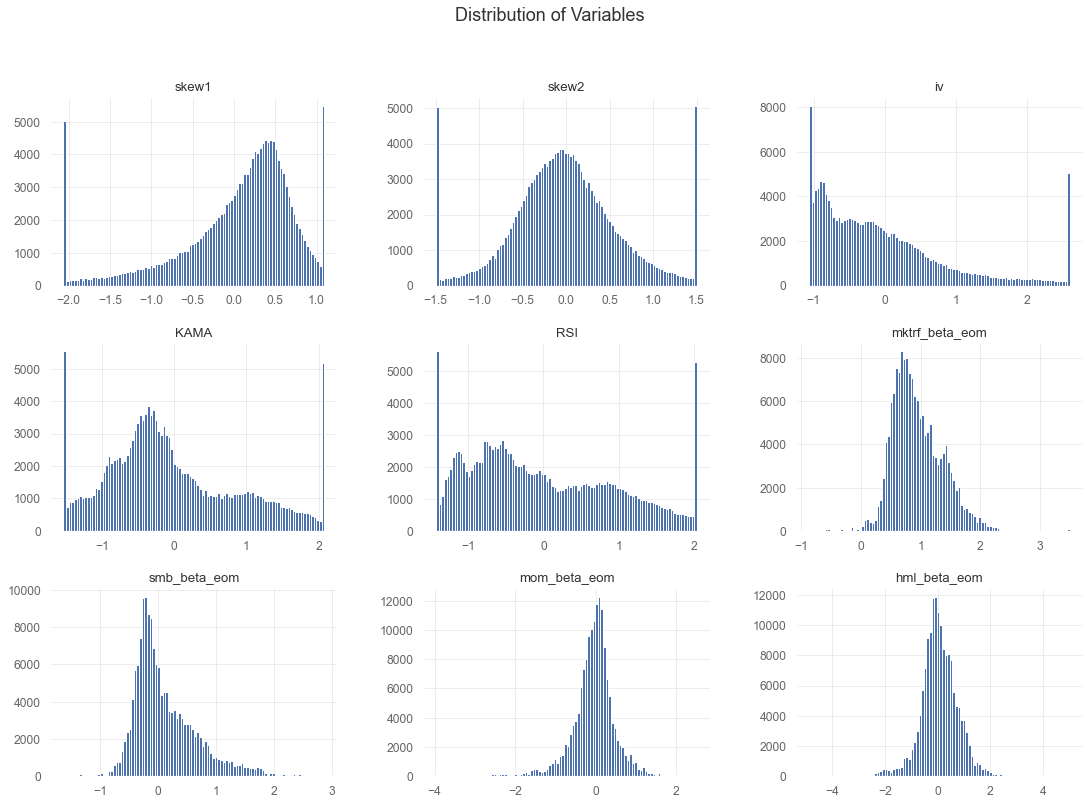

In [60]:
cols = ['skew1', 'skew2', 'iv', 'KAMA','RSI','mktrf_beta_eom','smb_beta_eom','mom_beta_eom','hml_beta_eom' ]#,'vrp', 'AroonInd']
fig, axs = plt.subplots(3,3)
fig.set_size_inches(18.5, 12.5, forward=True)
fig.suptitle('Distribution of Variables', fontsize=18)

for i,el in enumerate(cols):
    a = train.hist(el, ax=axs.flatten()[i],bins=100)


## Modelling the Prediction of Returns

In [61]:
def Rolling_Forest(data,predictors,target,window,params):

# First we form the window 
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

#Auxiliary placeholders and reg. constant
    data = data.sort_values(by=['date','permno'])
    predictions_df = pd.DataFrame(index=[pred_date], columns=np.sort(data.permno.unique()))
  #  scores = []
    missing_dates = []

# The train / predict loop
    while pred_date <= data.date.max():
        try:
            mask = ((data['date'] >= start_window) & (data['date'] <= end_window))
            train_window = data[mask].set_index('permno')
            linreg = RandomForestRegressor(**params)
            fit_ = linreg.fit(train_window[list(predictors)],train_window[target])
            predi_df = data[data['date']== pred_date].loc[:,list(predictors)+['permno']].set_index('permno')
            predi = fit_.predict(predi_df)
            one_predi = (pd.DataFrame(data = predi, index=predi_df.index,columns=[pred_date])).T
            predictions_df = pd.concat([predictions_df,one_predi], axis=0, ignore_index=False)
          #  score_r2 = linreg.score(train[predictors], train[target])
          #  scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
# Update window position        
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
# Real returns we will need

    # real_returns = data.pivot_table(index='date', columns='permno', values='fret1d')
    real_returns = data.pivot(index='date', columns='permno', values='fret1d')
    # r2_average = np.mean(scores)
    
    return real_returns, predictions_df[1:], missing_dates #, r2_average
    # return data

TODO: I see that the hyperparameters will be tuned once and not updated anymore, then the RandomForest model will apply the hyperparams all the time. The RF model will be rolled and use past 21 observations to make prediction of the next one.
--> Should be alright. I need to think about this.

TODO: Why rolling in train? train can be used at once...

TODO: I think it's better to have the model as an input of the function, so we can use different model for the function.

TODO: (more explanation)
I see that the model hyperparameters are tuned for the whole train set, but the params are trained for last 21 days data every day. Then effectively the model is overfitting the current few data points and capturing the autocorrelations of returns. Even rolling in test period, we are only using 21 days info. Imagine, there is a bull market, and positive returns can be in series, then the model can just ignore most of the factors and predict something positive. Even it comes to the turning point and there are signals in features. The model itself will be like a momentum. 

1. There is no need to roll in training set.
2. Only perfomance in test period should be considered (whether defeat benchmark).
3. Longer time period for more stable model should be used.

Should be 1. Data in 1999.01.01-2012.12.31 (randomize+CV) to train a model M1. Use data on 2012.12.31 and M1 predict 20130101, use the prediction  to get weight. Use data on 20130101 and M1 predict 20130102, use the prediction to get weight. ... until sometime e.g. 20130331, use data 20190401 - 20130331 to train model M2, and then use M2 to do the prediction. Until some other day e.g. 20130630, use data in 19990701 - 20130630 to train M3, and use M3 to predict. Everytime trained a new model, the scaling factors should be saved and applied to the following period until new model is trained.

In [62]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [63]:
params = {
        'n_estimators': [10, 20, 30],
        'max_features': ['sqrt','auto','log2'],
        'max_depth': [3, 4, 5],
        'min_samples_leaf':[1,2,3,4],
        'min_samples_split':[2,3,4,5]
        }

train.insert(10, 'constant', 1.0)
regressors = train.columns[10:-1]
target = ['fret1d']


forest = RandomForestRegressor()

folds = 3
param_comb = 5

random_search = RandomizedSearchCV(forest, param_distributions=params, n_iter=param_comb, scoring='r2', 
                                   n_jobs=4, cv=KFold(5), verbose=3, random_state=1001)
                                                #KFold is not shuffled !
    # TODO: I think it should be shuffled.

# Here we go 
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(train[regressors], train[target])
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 1 minutes and 2.8 seconds.


In [64]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=30)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
-1.0045645666229295

 Best hyperparameters:
{'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 5}


In [65]:
# params_forest = {
#     "n_estimators": 30,
#     'max_features':'sqrt', 
#     'max_depth':5,
#     'min_samples_leaf':3,
#     'min_samples_split':4,
#     'random_state':1001,
#     }
# TODO: Add here for more flexibility:
params_forest = random_search.best_params_.update({'random_state':1001})

#train.insert(10, 'constant', 1.0) MAKE SURE TO RUN IF NOT ALREADY INSERTED IN GRIDSEARCH !
regressors = train.columns[10:-1]
target = ['fret1d']

real_returns, expected_returns, missing_dates = Rolling_Forest(data=train, 
                                                              predictors=regressors,
                                                              target=target, 
                                                              window=21,
                                                              params=params_forest)

In [66]:
#expected_returns.to_hdf(hdf_path, key = 'Predictions', mode= 'a',data_columns = True, complib = 'zlib')
#real_returns.to_hdf(hdf_path, key = 'Real', mode= 'a',data_columns = True, complib = 'zlib')

In [67]:
regressors

Index(['constant', 'mktrf_beta_eom', 'smb_beta_eom', 'hml_beta_eom',
       'mom_beta_eom', 'ret_crude_oil_beta_eom', 'yield_dif_10y_1y_beta_eom',
       'ret_gold_beta_eom', 'glb3_D30', 'mfis91', 'skew1', 'iv', 'skew2',
       'KAMA', 'ROCI', 'RSI', 'EMA25', 'MACD', 'AroonInd'],
      dtype='object')

In [84]:
real_returns

permno,10874.0,11308.0,11404.0,11786.0,13856.0,16432.0,16600.0,17144.0,17750.0,18163.0,18411.0,18729.0,20482.0,21207.0,21776.0,22111.0,22752.0,24010.0,24109.0,24205.0,25320.0,26825.0,27959.0,42200.0,43449.0,45911.0,46578.0,47466.0,47626.0,48486.0,51369.0,52476.0,53065.0,53613.0,56274.0,61241.0,64936.0,69032.0,71298.0,75175.0,75341.0,76644.0,77649.0,80539.0,82598.0,83601.0,84519.0,85663.0,86102.0,88664.0
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021106,-0.017493,0.015625,-0.016467,-0.033962,-0.011450,-0.028714,0.009464,0.000000,0.059524,-0.007487,0.074097,0.030303,0.055238,0.032680,0.009494,-0.039301
2000-02-01,-0.006601,-0.030108,-0.011407,-0.021186,-0.029412,-0.031250,0.003082,-0.004132,0.001015,-0.008794,-0.007389,0.028302,0.005703,0.050314,0.003008,0.006632,0.000814,-0.022059,-0.001855,0.006051,-0.021231,-0.025445,-0.017372,-0.015796,-0.030717,0.105824,0.006510,-0.010782,-0.001862,0.044719,0.023152,0.023810,0.002594,0.037402,-0.038576,-0.013675,0.007610,0.017578,0.011583,-0.014139,0.003125,-0.002513,0.056180,0.141164,0.049275,0.009454,0.070397,-0.022152,0.050157,0.000000
2000-02-02,-0.039867,-0.019956,0.009615,0.004329,0.001894,-0.021505,0.016897,0.016598,0.013185,-0.008238,0.000893,-0.021407,0.005671,0.017964,0.043478,-0.024158,-0.008130,0.020050,0.033457,0.031579,0.017354,0.002611,-0.007735,0.006173,-0.014085,0.065511,-0.034929,0.038147,0.007463,0.021403,0.047868,0.011628,0.014230,0.032258,0.015432,0.081456,0.013595,0.017274,0.011450,0.022164,0.009346,-0.015113,-0.042553,-0.006610,0.013260,-0.001041,0.017707,-0.003236,0.055737,0.004545
2000-02-03,0.017301,0.018100,-0.017143,0.011853,-0.009452,-0.021978,0.003021,-0.008163,-0.014014,-0.031310,-0.022613,-0.062500,0.035714,0.158824,-0.011494,-0.014254,-0.015574,-0.019656,-0.019784,-0.029155,-0.038380,-0.026042,-0.041203,0.034356,0.003571,0.031344,-0.058981,0.014436,0.007407,-0.022292,-0.033223,-0.005747,0.021684,-0.009191,0.021277,-0.011218,-0.017884,-0.008491,0.109434,-0.022959,-0.006173,-0.005115,0.011111,0.082700,0.116140,-0.050000,0.001657,-0.016234,-0.016997,0.063348
2000-02-04,-0.057823,0.011111,-0.021318,0.043663,-0.011450,0.033708,-0.012048,0.006173,-0.003046,-0.015831,0.000000,0.002222,-0.018149,-0.076142,-0.023256,-0.008371,0.002498,-0.012531,-0.011009,0.001502,-0.013304,-0.024064,-0.013937,0.011862,-0.005338,0.044126,-0.027066,-0.042691,-0.034926,0.014136,0.057560,-0.014451,-0.011236,0.098330,-0.023810,0.053485,-0.007587,-0.008563,-0.034014,-0.069191,0.000000,-0.017995,-0.032967,0.039508,-0.020029,-0.004386,0.069479,-0.023102,0.020173,0.008511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-21,-0.005405,-0.004337,-0.001427,-0.010324,-0.002872,-0.003823,-0.004907,-0.002433,-0.003093,-0.002910,-0.004848,-0.000476,-0.008781,-0.007851,-0.007697,-0.003558,-0.002409,-0.002325,-0.005754,-0.000572,-0.003944,-0.000712,0.001085,0.003490,-0.009869,0.009462,-0.005269,-0.017381,-0.002143,0.019592,-0.012537,0.002609,-0.012556,-0.014241,-0.000671,-0.042471,0.000000,0.001586,0.011084,-0.005102,-0.003592,0.005012,-0.000862,-0.009859,-0.003548,-0.013307,-0.011965,0.004018,0.013347,0.006571
2012-12-24,-0.003623,-0.008440,-0.009112,-0.007072,-0.008498,0.010744,-0.011779,-0.007317,-0.003580,-0.007589,-0.006727,-0.003237,-0.006262,0.019218,-0.006408,0.002142,-0.001931,-0.015069,-0.009491,-0.011656,-0.009050,-0.006591,-0.007897,-0.008852,-0.006160,-0.023187,-0.007198,-0.017689,-0.003579,-0.013532,0.000000,-0.012639,-0.009991,-0.008828,-0.010746,-0.020161,-0.004428,-0.003694,0.010370,0.019231,-0.003605,0.008313,-0.007192,-0.030583,-0.004451,-0.002380,0.002549,-0.016896,-0.007317,-0.018579
2012-12-26,-0.001818,0.000000,-0.000721,-0.007123,-0.002469,0.018983,-0.001247,-0.002

In [85]:
expected_returns

,10874.0,11308.0,11404.0,11786.0,13856.0,16432.0,16600.0,17144.0,17750.0,18163.0,18411.0,18729.0,20482.0,21207.0,21776.0,22111.0,22752.0,24010.0,24109.0,24205.0,25320.0,26825.0,27959.0,42200.0,43449.0,45911.0,46578.0,47466.0,47626.0,48486.0,51369.0,52476.0,53065.0,53613.0,56274.0,61241.0,64936.0,69032.0,71298.0,75175.0,75341.0,76644.0,77649.0,80539.0,82598.0,83601.0,84519.0,85663.0,86102.0,88664.0
2000-03-01,-0.001850,-0.003593,-0.007744,0.019809,-0.004809,-0.005256,-0.007546,-0.005280,-0.007957,-0.005293,-0.003874,-0.006859,-0.002727,0.005827,-0.002833,-0.004058,-0.005723,-0.003710,-0.002802,-0.003072,-0.001214,-0.002582,-0.004528,0.013943,-0.001856,0.018550,-0.004535,-0.005708,-0.005813,0.008261,0.024161,-0.001631,0.002187,0.025375,-0.002161,0.018838,-0.005865,0.008984,0.000150,-0.008268,-0.005741,-0.001118,0.010585,0.027917,0.032763,-0.002130,0.063339,0.013846,0.007517,0.006615
2000-03-02,-0.001142,-0.001507,-0.007708,0.011073,-0.004508,-0.003146,-0.006835,-0.005320,-0.006053,-0.005211,-0.004973,-0.005565,-0.005171,-0.001438,0.000003,-0.000326,-0.006840,-0.004076,0.001378,-0.004830,0.003176,-0.002349,-0.004115,0.012807,-0.003231,-0.010858,-0.003087,-0.007100,-0.004088,0.004858,0.004863,-0.001149,0.000457,0.001371,-0.005652,0.009456,-0.006212,0.001685,0.005079,-0.006108,-0.003739,-0.000521,0.002312,0.013792,0.007666,-0.000434,0.024569,-0.008387,-0.002326,0.000872
2000-03-03,-0.002492,-0.003610,-0.003610,0.013642,-0.002684,-0.006310,-0.007261,-0.004464,-0.002945,-0.005494,-0.004322,-0.005737,-0.005236,-0.001190,-0.000150,-0.003583,-0.004701,-0.002940,-0.003234,-0.002709,0.003683,0.001825,0.004304,0.016909,-0.004674,-0.004609,-0.005065,-0.004930,-0.002263,0.003015,0.018157,0.001443,0.000815,0.007762,-0.000824,0.004992,-0.002672,0.007914,0.001161,-0.005302,-0.004221,-0.001767,0.010630,0.013104,0.024194,-0.001779,0.037131,0.000279,0.001302,0.003804
2000-03-06,0.001812,-0.006058,-0.005381,0.015847,-0.005099,-0.004234,-0.007078,-0.000016,-0.003367,-0.005512,-0.006691,-0.007211,-0.004667,-0.000507,0.002164,-0.002199,-0.004357,0.001570,-0.005287,-0.004397,-0.000773,-0.001981,0.003357,0.029266,-0.001706,0.009774,-0.006404,-0.006909,-0.003700,0.009113,0.009238,-0.003243,0.003388,-0.000223,-0.004871,0.022256,-0.007307,0.013287,0.000089,-0.000877,-0.006285,-0.003612,0.006723,0.023776,0.008690,0.004219,0.036365,0.003553,-0.002213,0.005702
2000-03-07,-0.001692,-0.008038,-0.009473,0.026920,-0.003775,-0.001597,-0.004864,-0.006632,-0.007947,-0.008413,-0.008639,-0.007400,-0.002922,0.010841,-0.005019,-0.005810,-0.006175,-0.000282,-0.001530,-0.005102,0.000865,0.003849,-0.005110,0.016909,-0.001778,0.003447,-0.004750,-0.008382,-0.000778,0.013540,0.004987,-0.004140,-0.003760,0.007977,-0.008408,0.028809,-0.007558,0.018255,0.005436,-0.006551,-0.005949,-0.001257,0.000943,0.027838,0.014526,-0.005665,0.004908,0.005473,-0.005295,0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-21,0.003324,0.001126,0.001375,0.003169,0.001103,0.004679,0.001567,0.001062,0.001104,0.001024,0.001374,0.000717,0.001049,-0.000600,0.000007,0.000863,-0.000112,0.000692,0.000800,0.000647,0.001198,0.001030,0.001307,0.001596,0.000193,-0.000867,-0.000048,0.000965,0.001286,0.002300,0.002827,0.002117,0.002487,0.013319,0.001159,0.012109,0.001276,0.006114,0.000388,0.001645,0.002069,0.004242,0.001414,0.002076,0.001565,0.005613,0.005378,0.003250,0.003360,0.001618
2012-12-24,0.003404,0.000274,0.000651,0.000389,0.000651,0.002247,0.000637,0.000556,0.000488,0.000661,0.000519,0.000783,0.000429,0.000376,0.000616,0.000451,0.000820,0.001273,0.001074,0.000600,0.000615,0.000539,0.000950,-0.000042,0.000658,0.000882,0.000148,0.001440,0.001386,0.001169,0.002271,0.003122,0.000980,0.003417,0.000682,-0.001922,0.001311,0.003114,-0.000436,0.000022,0.001652,0.002848,0.000977,0.002468,0.001284,0.005663,0.000609,0.002737,0.001813,0.000862
2012

## Backtest

In [68]:
def prepare_returns(real, expected, days_to_test):


    real = real.loc[np.logical_and(real.index >= days_to_test - pd.Timedelta(days=252*5 + 1), 
                                   real.index < days_to_test), :]
    expected = expected.loc[np.logical_and(expected.index >= days_to_test - pd.Timedelta(days=252*5 + 1), 
                                           expected.index < days_to_test), :]   
    
    real = real.fillna(0.0)
    expected = expected.fillna(0.0)
    
    return real, expected

In [69]:
def MSR(wvec,*args):
    cov = args[0]
    mu  = args[1]  # Max Sharp Ratio
    sr = mu@wvec/(wvec@cov@wvec)
    return -sr / 100000

In [70]:
def Benchmark_Drawdown_Rolling(df,ret,d,lookback):
    
    d = pd.Timestamp(d)
    start = d - BDay(lookback)
    
    means = ret.loc[start:(d-BDay(1)),:].values
    
    weights_bench = df[(df['date']>= start) & (df['date'] < d)]
    weights_bench = weights_bench[['date','permno','weightage_pct']]
    weights_bench = weights_bench.pivot(index = 'date',columns = 'permno',values='weightage_pct')
    
    monthly_benchmark_returns = (means*weights_bench).sum(axis=1)
    monthly_benchmark_returns = pd.DataFrame(monthly_benchmark_returns,columns=["Benchmark_Return"])
    # cumulative return
    monthly_benchmark_returns['Cum_ret'] = (1+ monthly_benchmark_returns['Benchmark_Return']).cumprod()
    # cumulative peaks
    monthly_benchmark_returns['Peaks'] = monthly_benchmark_returns['Cum_ret'].cummax()
    # drawdown from trailing peak
    monthly_benchmark_returns['Drawdown'] = (monthly_benchmark_returns['Cum_ret'] - monthly_benchmark_returns['Peaks']) / monthly_benchmark_returns['Peaks']
    
    return monthly_benchmark_returns, monthly_benchmark_returns['Drawdown'].min()

In [ ]:
# TODO: I add Max DD function
# The benchmark return & (level) can be calculated at the begining and save to a DataFrame,
# So we don't need to calculate in every loop. --> More efficient
# The max DD function can also be used for portfolio.

def Max_Drawdown(df_ret, d, lookback):
    """
    Input:
        df_ret: a dataframe with date as index and daily return of BNCH or PORT as a column.
        d: a date
        
    """
    d = pd.Timestamp(d)
    start = d - BDay(lookback)
    period_ret = df_ret.loc[start:(d-BDay(1)),:]
    
    period_ret['Cum_ret'] = (1+period_ret['ret']).cumprod()
    return ((period_ret['Cum_ret'] / period_ret['Cum_ret'].cummax()).cummin()).min() - 1

In [71]:
def configure_inputs_for_optimisation(df, ret, expret, d, limit,lookback):

    cov = ret.cov().values
    mu  = expret.iloc[-1].values
    
    if np.sum(mu > 0) == 0:
        mu -= mu.mean()
    
 # ----- Bounds on Weights Based on Benchmark on day d  ---- #
    bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
    for en,i in enumerate(ret.columns, start=0): # 
        
        lower_bound = 0.9*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
        higher_bound = 1.1*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
        bounds[en].extend((lower_bound,higher_bound))
              
 # ----- Constraints on Factor Exposure: ---- #
    cons = []
    fact = pd.DataFrame(columns=list(regressors)+['permno'] )
    fact.permno = ret.columns.tolist()
    fact.set_index('permno', inplace=True)
    fact = fact.fillna(0.0)
    
    for stock in fact.index:
        for fct in fact.columns:
            flt = np.logical_and(df['date'] == d, df['permno'] == stock)
            if flt.any():
                fact.loc[stock, fct] = train.loc[flt, fct].values[0]
    
    B = fact.T
    
    cons.append({'type': 'ineq', 'fun' : lambda wvec: limit - B@wvec})
    cons.append({'type': 'ineq', 'fun' : lambda wvec: B@wvec + limit}) 
 
 # ----- Constraints on Weight Sum (long portfolio): ---- #

    cons.append({'type': 'eq', 'fun' : lambda wvec: wvec.sum()-1})
    
#  # ----- Constraints on Drawdown: ---- #
    if (pd.Timestamp(d)- BDay(lookback)) in ret.index:
        _,benchmark_dd = Benchmark_Drawdown_Rolling(df,ret,d,21)
        cons.append({'type': 'ineq', 'fun' : lambda
                     wvec: mu.T@wvec-(benchmark_dd-0.01)})   
    # TODO: daily portfolio return < bnch max dd - 1% does not be equivalent to the monthly drawdown constraint.
    # e.g. monthly max dd = -10%
    # daily return -1%, which does not exceed monthly max dd at all, but if this continuous for 11 days, 
    # then the constraint is breached.
    
    return cov, mu, cons, bounds

## Sanity Check on Weight Bounds

In [96]:
# dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
# dt_m = dtall.groupby(pd.Grouper(freq='B')).last() # We can rebalane daily for final solution should be better results
# dates_rebal = dt_m.index.values                   # But less realistic (daily trading)

In [103]:
dtall = pd.DataFrame(index = expected_returns.index, data = expected_returns.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='B')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values                   # But less realistic (daily trading)


In [104]:
dates_rebal

array(['2000-03-01T00:00:00.000000000', '2000-03-02T00:00:00.000000000',
       '2000-03-03T00:00:00.000000000', ...,
       '2012-12-26T00:00:00.000000000', '2012-12-27T00:00:00.000000000',
       '2012-12-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [105]:
# bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
# d = dates_rebal[0]
# for en,i in enumerate(ret.columns, start=0): # 

#     lower_bound = 0.9*float(train.loc[train['date']==d][train['permno']== i].weightage_pct.values)
#     higher_bound = 1.1*float(train.loc[train['date']==d][train['permno']== i].weightage_pct.values)
#     bounds[en].extend((lower_bound,higher_bound))

bounds = [ [] for _ in range(len(real_returns.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
d = dates_rebal[0]
for en,i in enumerate(real_returns.columns, start=0): # 

    lower_bound = 0.9*float(train.loc[(train['date']==d) & (train['permno']== i), 'weightage_pct'])  # TODO: Changed to more readable syntax
    higher_bound = 1.1*float(train.loc[(train['date']==d) & (train['permno']== i), 'weightage_pct'])
    bounds[en].extend((lower_bound,higher_bound))

In [110]:
bounds[11] # Alles gut ! 

[0.025982150986644945, 0.03175596231701049]

In [112]:
train.loc[train['date']==dates_rebal[0]][train['permno']== expected_returns.columns[11]].weightage_pct.values

array([0.02886906])

## Sanity Check on Factor Exposure

In [123]:
regressors

Index(['constant', 'mktrf_beta_eom', 'smb_beta_eom', 'hml_beta_eom',
       'mom_beta_eom', 'ret_crude_oil_beta_eom', 'yield_dif_10y_1y_beta_eom',
       'ret_gold_beta_eom', 'glb3_D30', 'mfis91', 'skew1', 'iv', 'skew2',
       'KAMA', 'ROCI', 'RSI', 'EMA25', 'MACD', 'AroonInd'],
      dtype='object')

In [124]:
# fact = pd.DataFrame(columns=regressors+['permno'] )
# fact.permno = expected_returns.columns.tolist()
fact = pd.DataFrame(columns=list(regressors)+['permno'] )
fact['permno'] = expected_returns.columns.tolist()
fact.set_index('permno', inplace=True)
fact = fact.fillna(0.0)

In [126]:
for stock in fact.index:
    for fct in fact.columns:
        flt = np.logical_and(train['date'] == dates_rebal[0], train['permno'] == stock)
        if flt.any():
            fact.loc[stock, fct] = train.loc[flt, fct].values[0]

In [127]:
fact

,constant,mktrf_beta_eom,smb_beta_eom,hml_beta_eom,mom_beta_eom,ret_crude_oil_beta_eom,yield_dif_10y_1y_beta_eom,ret_gold_beta_eom,glb3_D30,mfis91,skew1,iv,skew2,KAMA,ROCI,RSI,EMA25,MACD,AroonInd
permno,,,,,,,,,,,,,,,,,,,
10874.0,1.0,1.040805,0.670140,0.434654,-0.827728,0.031569,0.009679,-0.091471,0.027901,-0.045106,0.725497,0.326750,-0.758753,2.076317,8.045977,-0.695021,54.243705,2.760684,8.0
11308.0,1.0,0.518623,-0.388111,-0.586461,-0.820430,0.002395,0.000122,-0.016150,0.042911,0.020604,0.829453,-0.080179,-0.635178,2.076317,32.899023,-0.069983,53.994189,2.118902,8.0
11404.0,1.0,0.617318,-0.181146,0.685530,-0.191641,-0.077431,0.004723,-0.070408,0.037433,0.539542,0.572160,-0.195525,0.319751,2.076317,47.619048,-0.513724,51.927328,1.191375,8.0
11786.0,1.0,1.220875,0.479177,1.479590,0.241929,0.086231,-0.011382,-0.058912,0.036239,-0.041639,1.092052,1.205925,-1.024002,2.076317,266.000000,0.511073,54.091572,0.975242,8.0
13856.0,1.0,0.410609,-0.439740,-0.676034,-0.630524,0.035231,0.001659,-0.028313,0.041668,-0.127433,1.031330,-0.164732,-0.536811,2.076317,236.129032,-0.418951,52.435490,0.456270,8.0
16432.0,1.0,1.128347,0.177622,1.049252,-0.737024,-0.094773,-0.004129,0.206124,0.043018,0.058294,0.670747,0.815217,-0.609915,2.076317,-78.641975,-0.631869,50.065452,-0.400852,8.0
16600.0,1.0,0.545884,-0.363985,-0.320146,-0.563199,-0.031200,-0.000102,-0.024175,0.038663,-0.470571,-0.029203,-0.262535,0.540719,2.076317,-76.258278,-0.127717,49.661379,-1.054131,8.0
17144.0,1.0,0.425959,-0.209123,0.047990,-0.418344,-0.054786,0.003957,-0.022589,0.041708,-0.288070,-0.311784,-0.389912,-0.404215,2.076317,150.471698,-0.382011,48.394157,-1.728467,8.0
17750.0,1.0,0.798704,-0.246535,0.339059,-0.522946,-0.024809,0.002469,-0.017794,0.041247,-0.586550,0.298376,0.049945,0.034384,2.076317,-69.417286,-0.009633,48.431145,-2.126427,8.0


## Run the whole loop on Weekly rebalance

In [128]:
# dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
dtall = pd.DataFrame(index = expected_returns.index, data = expected_returns.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='B')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values# But less realistic (daily trading)

# We need to also exclude from rebalance dates the business days that were actually not trading days
missing_dates = [i.to_datetime64() for i in missing_dates] # Uncomment if needed a convert!
dates_rebal = [x for x in dates_rebal if x not in missing_dates]

In [130]:
# names = ret.columns
names = expected_returns.columns
ptf = {} 

# Initiate a dictionary of placeholders for the 3 strategies
ptf['msr_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = names)

In [131]:
ptf['msr_w_cons']

,10874.0,11308.0,11404.0,11786.0,13856.0,16432.0,16600.0,17144.0,17750.0,18163.0,18411.0,18729.0,20482.0,21207.0,21776.0,22111.0,22752.0,24010.0,24109.0,24205.0,25320.0,26825.0,27959.0,42200.0,43449.0,45911.0,46578.0,47466.0,47626.0,48486.0,51369.0,52476.0,53065.0,53613.0,56274.0,61241.0,64936.0,69032.0,71298.0,75175.0,75341.0,76644.0,77649.0,80539.0,82598.0,83601.0,84519.0,85663.0,86102.0,88664.0
2000-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Optimization rutine for the 2 minimization problems and for the closed form solution
st_point_msr = None
for d in dates_rebal: 
    print(d)    
    start_time = time.time()

    ret, expret = prepare_returns(real_returns,expected_returns,d)

    # we prepare inputs:
    cov,mu,cons,bounds = configure_inputs_for_optimisation(train, ret, expret, d, 0.05,21)

    # define starting point
    if st_point_msr is None:
        st_point_msr = np.ones(ret.columns.size)/ret.columns.size

    # run optimisation, MSR
    res = minimize(MSR,
                st_point_msr,
                args = (cov, mu), 
                constraints = cons, 
                bounds = bounds, 
                method = 'SLSQP',
                options={'ftol': 1e-16, 'disp': False})
    print("MSR: " + res.message)
    # store results
#     i = 0
#     for col in ret.columns:
#         ptf['msr_w_cons'].loc[d, col] = res.x[i]
#         i += 1
    ptf['msr_w_cons'].loc[d] = res.x
  
    # Set next starting point
    st_point_msr = res.x

    
    print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
def clc_str_return(w, ret, str_name):
    w_i = np.zeros(len(ret.columns.tolist()))
    ret_str = pd.DataFrame(index = ret.index, columns=[str_name])
    for i in ret.index:
        ret_str.loc[i, str_name] = w_i@ret.loc[i,:]
        #ret_str.loc[i, str_name] = np.sum(w_i)
        if i in w.index:
            w_i = w.loc[i,:]
            
            
    return ret_str

TODO: There is a tiny issue here:

**You are assuming weekly rebalancing, but effectively you are rebalancing everyday.**

The function shows that a new weights will be derived for every week and be applied until the next rebalancing. In order to keep the weights constant during this period, your portfolio is rebalancing everyday because the prices of shares will change.

e.g. Assuming 2 shares in a portfolio, A, B, each costs 10 EUR today. We have 1,000 EUR and need 50-50 weights. Then it will be 50 shares A vs 50 shares B.
Tomorrow, the prices changed to 10.5 and 9.8 EUR. The total portfolio value is 1,015 EUR. In order to assume further 50-50 weights, you will need to rebalance to 48.33 shares of A and 51,79 shares of B. Only when you keep the WEIGHTS constant, you can use the weights @ return to calculate the portfolio return.

If the original idea is to keep the absolute number of shares during the rebalancing period (more natural sense), then the return can only be calculated via daily portfolio value or with new weights, and the constant weights @ return will not be valid anymore.

e.g. in above case, assuming 50 shares A and B constant. Tomorrow, the weights will be 51.7% and 48.3%, this weights should be used to multiple with the tomorrow's return, while in the above function, 50-50 is still applied.

Assuming the day after, the prices become 10.6 and 9.5. The total portfolio value will be 1,005 EUR. Daily return will be -10/1015 = -0.985%. If use 50-50 percentage and the individual return, it will be 0.1 / 10.5 * 0.5 + -0.3 / 9.8 * 0.5 = -1.05%. If use new weights 0.517 vs 0.483, it will be -0.985%.

Therefore, **The above function is only valid when daily rebalancing.** It would be easier to not considering different rebalancing period and stick to daily rebalancing.

In [ ]:
ret_str = clc_str_return(ptf['msr_w_cons'], ret, 'msr_w_cons')

In [ ]:
rep_ = qs.reports.html(ret_str['msr_w_cons'])

## Compare with Benchmark

In [ ]:
ret_str.index.min()

In [ ]:
bnch_ret = (df_betas.groupby(['date']).apply(weighted_avg, 'excess_return', 'weightage_pct')+1).cumprod()*100
bnch_ret = bnch_ret.loc[(bnch_ret.index >= ret_str.index.min()) & (bnch_ret.index <= ret_str.index.max())]

In [ ]:
rep_ = qs.reports.html(ret_str['msr_w_cons'],bnch_ret)

**TODO: General Logic**

1. Train in training set (<20121231)
    * Match features and forward returns.
    * **Randomize the training set** so that different cases (e.g. 2008 crush) can be covered in both train and valid set.
    * Split train and valid further to tune the model (if Neural Network) or make CV (if Random Forest)
    * func [Data Engineering] for train:
              a. Cox-Box / Yeo-Johnson to normalize
              b. Winsorize
              c. Scaling
              Save hyperparams from a.b.c.
    * func [Data Engineering] for valid (if Neural Network) using the hyperparams from above step.
    * Build [Prediction Model] & tune with valid (if Neural Network) or CV (if Random Forest)
    
2. Looping through dates in test period (>20121231)
    * For each date:
            a. [Data Engineering] for daily data use the saved hyperparams from pervious train period.
            b. [Prediction Model] get predicted returns
            c. [Optimizer] get weights with covariance from previous period and predicted returns as inputs.
    * At certain date (e.g. Monthly end, or Shock in the benchmark)
            a. Rerun step 1 by use the data up-to-date as new training set. This training set should also be in a rolling fashion e.g. from 19990401 to 20130331, or including all previous period, such that the model will not be just overfitting on recent period but be updated with considering also the information from the past.